First we'll import the libraries we'll need to get the data and run some EDA with it.

Quandl provides access to a lot of datasets that can be useful for financial analysis

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import quandl

plt.style.use('ggplot')

In [5]:
quandl.ApiConfig.api_key = "amzzCgk_XEuyJSsMuLJ3"

Let's look at some spot rates for FX provided by the European central bank. These prints are all taken at the same time each day, give us a single value rather than bid/ask, and should be relatively immune to abnormal prints. WM/Reuters print could also be used here for stable prints if bid/ask prices of interest. 

In [35]:
codes = ["ECB/EURAUD"]
codes.append("ECB/EURCAD")
codes.append("ECB/EURCHF")
codes.append("ECB/EURCNY")
codes.append("ECB/EURGBP")
codes.append("ECB/EURHKD")
codes.append("ECB/EURIDR")
codes.append("ECB/EURJPY")
codes.append("ECB/EURKRW")
codes.append("ECB/EURMYR")
codes.append("ECB/EURNOK")
codes.append("ECB/EURNZD")
codes.append("ECB/EURPHP")
codes.append("ECB/EURRUB")
codes.append("ECB/EURSEK")
codes.append("ECB/EURSGD")
codes.append("ECB/EURTHB")
codes.append("ECB/EURTRY")
codes.append("ECB/EURUSD")
codes.append("ECB/EURZAR")

We'll download the data from Quandl with an API call, and look to see what we got.

In [36]:
start_date = '2018-01-02'
end_date = '2019-02-22'
data = quandl.get(codes,start_date = start_date,end_date = end_date)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2018-01-02 to 2019-02-22
Data columns (total 20 columns):
ECB/EURAUD - Value    293 non-null float64
ECB/EURCAD - Value    293 non-null float64
ECB/EURCHF - Value    293 non-null float64
ECB/EURCNY - Value    293 non-null float64
ECB/EURGBP - Value    293 non-null float64
ECB/EURHKD - Value    293 non-null float64
ECB/EURIDR - Value    293 non-null float64
ECB/EURJPY - Value    293 non-null float64
ECB/EURKRW - Value    293 non-null float64
ECB/EURMYR - Value    293 non-null float64
ECB/EURNOK - Value    293 non-null float64
ECB/EURNZD - Value    293 non-null float64
ECB/EURPHP - Value    293 non-null float64
ECB/EURRUB - Value    293 non-null float64
ECB/EURSEK - Value    293 non-null float64
ECB/EURSGD - Value    293 non-null float64
ECB/EURTHB - Value    293 non-null float64
ECB/EURTRY - Value    293 non-null float64
ECB/EURUSD - Value    293 non-null float64
ECB/EURZAR - Value    293 non-null float64
dtypes: float64(

No non-null values which is nice. Let's convert spot rates to log-returns, and then check to see if we've included any pegged currencies in our dataset. 

In [37]:
roll = 5
log_data = pd.DataFrame(np.log(data.iloc[roll:,:].values/data.iloc[:-roll,:].values),
                       columns = [elem[4:] for elem in codes],
                       index = data.index[roll:])
log_data.corr()[log_data.corr()!= 1].max()

EURAUD    0.724195
EURCAD    0.616673
EURCHF    0.568776
EURCNY    0.775217
EURGBP    0.293718
EURHKD    0.995817
EURIDR    0.751146
EURJPY    0.604325
EURKRW    0.752003
EURMYR    0.833085
EURNOK    0.455530
EURNZD    0.724195
EURPHP    0.838071
EURRUB    0.386986
EURSEK    0.455530
EURSGD    0.833085
EURTHB    0.815190
EURTRY    0.356561
EURUSD    0.995817
EURZAR    0.415660
dtype: float64

HKD and USD have suspiciously high correlations. A quick google will confirm the HKD is peggeed to the USD, and if we include this in our later analysis the USD will be over represented in our risk analysis. 

We'll drop the EURHKD from our codes, and download a larger dataset that we will use for analysis. 

In [40]:
codes.remove('ECB/EURHKD')
start_date = '2010-01-04'
end_date = '2019-02-22'
data = quandl.get(codes,start_date = start_date,end_date = end_date)

roll = 5
log_data = pd.DataFrame(np.log(data.iloc[roll:,:].values/data.iloc[:-roll,:].values),
                       columns = [elem[4:] for elem in codes],
                       index = data.index[roll:])
log_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2337 entries, 2010-01-11 to 2019-02-22
Data columns (total 19 columns):
EURAUD    2337 non-null float64
EURCAD    2337 non-null float64
EURCHF    2337 non-null float64
EURCNY    2337 non-null float64
EURGBP    2337 non-null float64
EURIDR    2337 non-null float64
EURJPY    2337 non-null float64
EURKRW    2337 non-null float64
EURMYR    2337 non-null float64
EURNOK    2337 non-null float64
EURNZD    2337 non-null float64
EURPHP    2337 non-null float64
EURRUB    2337 non-null float64
EURSEK    2337 non-null float64
EURSGD    2337 non-null float64
EURTHB    2337 non-null float64
EURTRY    2337 non-null float64
EURUSD    2337 non-null float64
EURZAR    2337 non-null float64
dtypes: float64(19)
memory usage: 365.2 KB


In [45]:
data[['EURAUD','EURUSD']].iloc[0:6,:]

,EURAUD,EURUSD
Date,,
2010-01-04,1.5885,1.4389
2010-01-05,1.5769,1.4442
2010-01-06,1.5677,1.4350
2010-01-07,1.5611,1.4304
2010-01-08,1.5610,1.4273
2010-01-11,1.5593,1.4528


In [46]:
log_data[['EURAUD','EURUSD']].iloc[0]

EURAUD   -0.018553
EURUSD    0.009614
Name: 2010-01-11 00:00:00, dtype: float64

In [48]:
u, s, vh = np.linalg.svd(log_data.corr())

In [51]:
s/s.sum()

array([0.48119896, 0.12266002, 0.05490107, 0.04938134, 0.0452264 ,
       0.03827409, 0.0357852 , 0.02892047, 0.02551458, 0.02157045,
       0.01934822, 0.01773406, 0.01291361, 0.01175909, 0.01052139,
       0.00959689, 0.00804107, 0.0043352 , 0.0023179 ])

In [66]:
num_components = 6
s[0:num_components].sum()

15.041195638783508

In [69]:
window = 120
length = 20
num_windows = (len(log_data)-120)//length+1
num_components = 6
explained = np.zeros((num_components+1,num_windows))
pc1_score = np.zeros((log_data.shape[1],num_windows))

for i in range(num_windows):
    sub_log = log_data.iloc[i*length:(i*length)+window,:]
    u, s, vh = np.linalg.svd(sub_log.corr())
    pc1_score[:,i] = u[:,0]
    explained[0,i] = s[0:num_components].sum()/s.sum()
    explained[1:,i] = s[0:num_components]/s.sum()

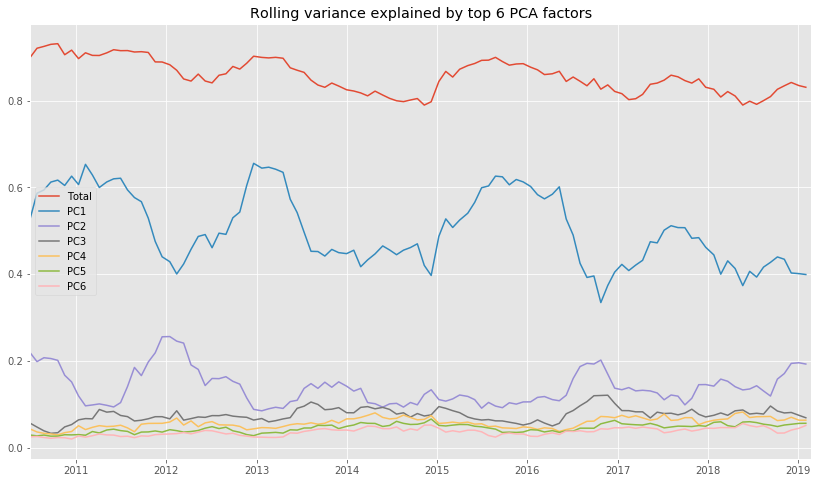

In [81]:
fig, ax = plt.subplots(1,1,figsize = (14,8))

labels = ['Total']+["PC"+str(i+1) for i in list(np.arange(num_components))]
for i in range(num_components+1):
    ax.plot(log_data.index[window::length],
            explained[i,:], label = labels[i])
ax.set_title('Rolling variance explained by top {} PCA factors'.format(num_components))
ax.legend()
ax.set_xlim((log_data.index[window],log_data.index[-1]))
plt.show()

We are able to explain 80% or more of the variance for most of our windows, which suggests there may be some utility from PCA with this data set. The 3 lowest factors seem pretty small though, so we might want to take a closer look

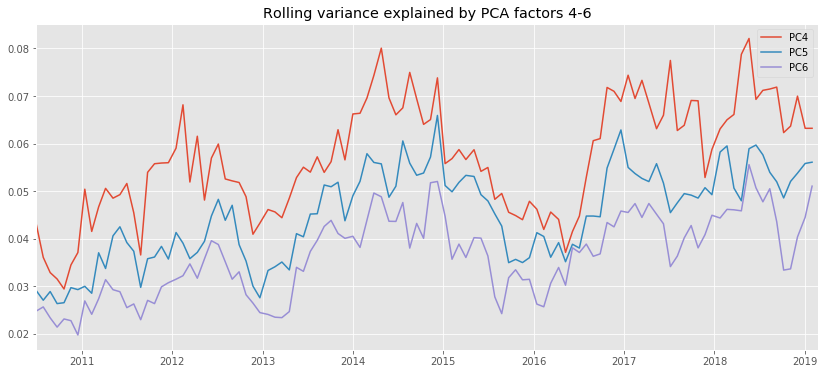

In [83]:
fig, ax = plt.subplots(1,1,figsize = (14,6))

labels = ['Total']+["PC"+str(i+1) for i in list(np.arange(num_components))]
for i in range(4,num_components+1):
    ax.plot(log_data.index[window::length],
            explained[i,:], label = labels[i])
ax.set_title('Rolling variance explained by PCA factors 4-6'.format(num_components))
ax.legend()
ax.set_xlim((log_data.index[window],log_data.index[-1]))
plt.show()

The 6th principal component seems a bit low, so maybe we'll only use the top five to reduce the risk of adding noise without losing much in the way of variance explained.

So now we may have a decent framework to look deeper into constructing an FX risk model. But let's pause to consider what risk we are actually looking at: all of the currency crosses we've been looking at have been with respect to the Euro. What if we want to look at AUDJPY or GBPUSD? This model will probably not do a great job giving us those kind of insights.

In order to construct a GLOBAL risk model we need to consider risk without respect to a particular currency.

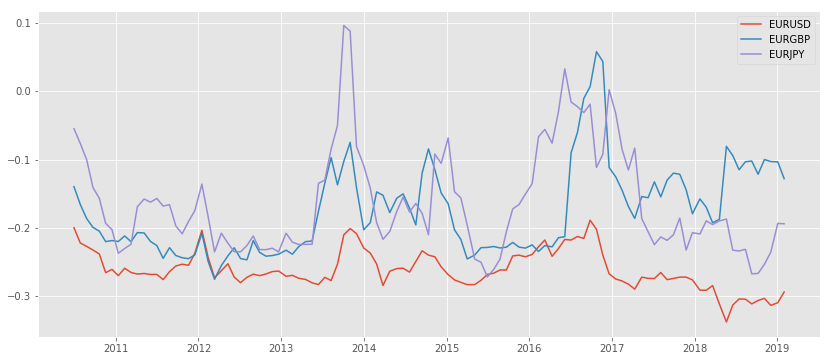

In [91]:
pc1 = pd.DataFrame(pc1_score.transpose(),
                   columns = [elem[4:] for elem in codes],
                   index = log_data.index[window::length])

fig, ax = plt.subplots(1,1,figsize = (14,6))
ax.plot(pc1.index,pc1['EURUSD'].values,label ='EURUSD')
ax.plot(pc1.index,pc1['EURGBP'].values,label ='EURGBP')
ax.plot(pc1.index,pc1['EURJPY'].values,label ='EURJPY')
ax.legend()
plt.show()

In [100]:
window = 120
length = 20
num_windows = (len(log_data)-120)//length+1
num_components = 5
explained = np.zeros((num_components+1,num_windows))
pc1_score_rot = np.zeros((log_data.shape[1],num_windows))

i = 0
sub_log = log_data.iloc[i*length:(i*length)+window,:]
u, s, vh = np.linalg.svd(sub_log.corr())
pc1_score_rot[:,i] = u[:,0]
explained[0,i] = s[0:num_components].sum()/s.sum()
explained[1:,i] = s[0:num_components]/s.sum()

prior_u = u[:,0:num_components]

for i in range(1,num_windows):
    sub_log = log_data.iloc[i*length:(i*length)+window,:]
    u, s, vh = np.linalg.svd(sub_log.corr())
    r = proc.procrustes(u[:,0:num_components],prior_u)
    prior_u = np.matmul(u[:,0:num_components],r)
    pc1_score_rot[:,i] = prior_u[:,0]
    explained[0,i] = s[0:num_components].sum()/s.sum()
    explained[1:,i] = s[0:num_components]/s.sum()


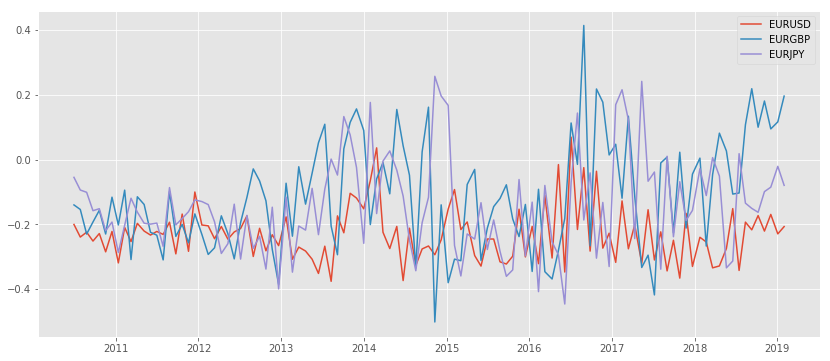

In [103]:
pc1_rot = pd.DataFrame(pc1_score_rot.transpose(),
                   columns = [elem[4:] for elem in codes],
                   index = log_data.index[window::length])

fig, ax = plt.subplots(1,1,figsize = (14,6))
ax.plot(pc1_rot.index,pc1_rot['EURUSD'].values,label ='EURUSD')
ax.plot(pc1_rot.index,pc1_rot['EURGBP'].values,label ='EURGBP')
ax.plot(pc1_rot.index,pc1_rot['EURJPY'].values,label ='EURJPY')
ax.legend()
plt.show()

In [118]:
log_data_all = log_data.copy(deep=True)

fx = [elem[-3:] for elem in codes]
#We'll put GBP and USD at the top of the list so they appear in the conventional manner
fx.remove('USD')
fx.remove('GBP')
fx.insert(0,'USD')
fx.insert(0,'GBP')
for i in range(len(fx)):
    for j in range(i+1,len(fx)):
        log_data_all[fx[i]+fx[j]]=log_data['EUR'+fx[j]]-log_data['EUR'+fx[i]]

In [95]:
import proc

In [125]:
window = 120
length = 20
num_windows = (len(log_data_all)-120)//length+1
num_components = 6
explained = np.zeros((num_components+1,num_windows))
pc1_score = np.zeros((log_data_all.shape[1],num_windows))

for i in range(num_windows):
    sub_log = log_data_all.iloc[i*length:(i*length)+window,:]
    u, s, vh = np.linalg.svd(sub_log.corr())
    pc1_score[:,i] = u[:,0]
    explained[0,i] = s[0:num_components].sum()/s.sum()
    explained[1:,i] = s[0:num_components]/s.sum()

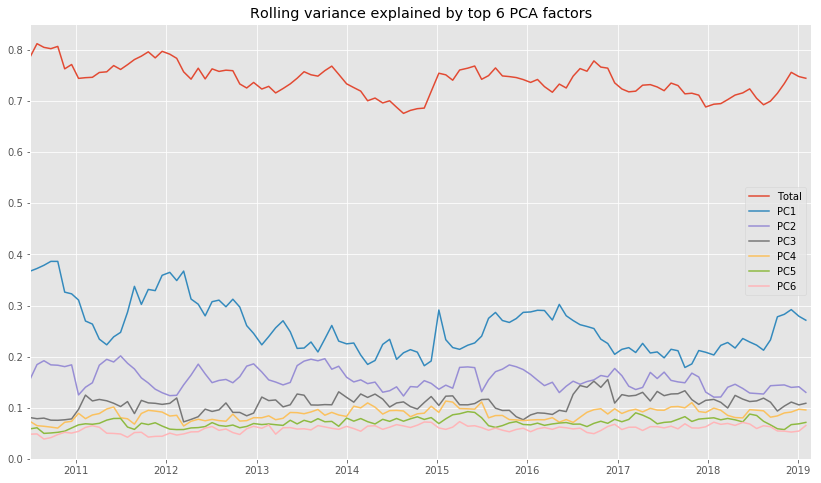

In [126]:
fig, ax = plt.subplots(1,1,figsize = (14,8))

labels = ['Total']+["PC"+str(i+1) for i in list(np.arange(num_components))]
for i in range(num_components+1):
    ax.plot(log_data.index[window::length],
            explained[i,:], label = labels[i])
ax.set_title('Rolling variance explained by top {} PCA factors'.format(num_components))
ax.legend()
ax.set_xlim((log_data.index[window],log_data.index[-1]))
plt.show()

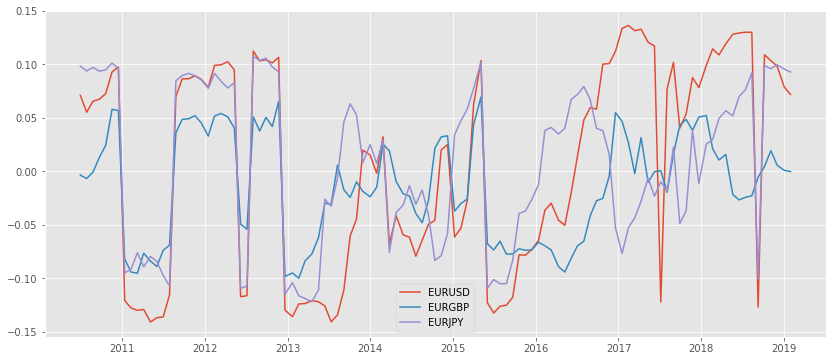

In [127]:
pc1 = pd.DataFrame(pc1_score.transpose(),
                   columns = log_data_all.columns,
                   index = log_data_all.index[window::length])

fig, ax = plt.subplots(1,1,figsize = (14,6))
ax.plot(pc1.index,pc1['EURUSD'].values,label ='EURUSD')
ax.plot(pc1.index,pc1['EURGBP'].values,label ='EURGBP')
ax.plot(pc1.index,pc1['EURJPY'].values,label ='EURJPY')
ax.legend()
plt.show()

In [194]:
window = 120
length = 5
num_windows = (len(log_data_all)-window)//length+1
num_components = 5
explained = np.zeros((num_components+1,num_windows))
pc1_score_rot = np.zeros((log_data_all.shape[1],num_windows))
pc1_score = np.zeros((log_data_all.shape[1],num_windows))

i = 0
sub_log = log_data_all.iloc[i*length:(i*length)+window,:]
u, s, vh = np.linalg.svd(sub_log.corr())
pc1_score_rot[:,i] = u[:,0]
pc1_score[:,i] = u[:,0]
explained[0,i] = s[0:num_components].sum()/s.sum()
explained[1:,i] = s[0:num_components]/s.sum()

prior_u = u[:,0:num_components]

for i in range(1,num_windows):
    sub_log = log_data_all.iloc[i*length:(i*length)+window,:]
    u, s, vh = np.linalg.svd(sub_log.corr())
    r = proc.procrustes(u[:,0:num_components],prior_u)
    prior_u = np.matmul(u[:,0:num_components],r)
    #prior_u = proc2(u[:,0:num_components],prior_u)
    pc1_score[:,i] = u[:,0]
    pc1_score_rot[:,i] = prior_u[:,0]
    explained[0,i] = s[0:num_components].sum()/s.sum()
    explained[1:,i] = s[0:num_components]/s.sum()

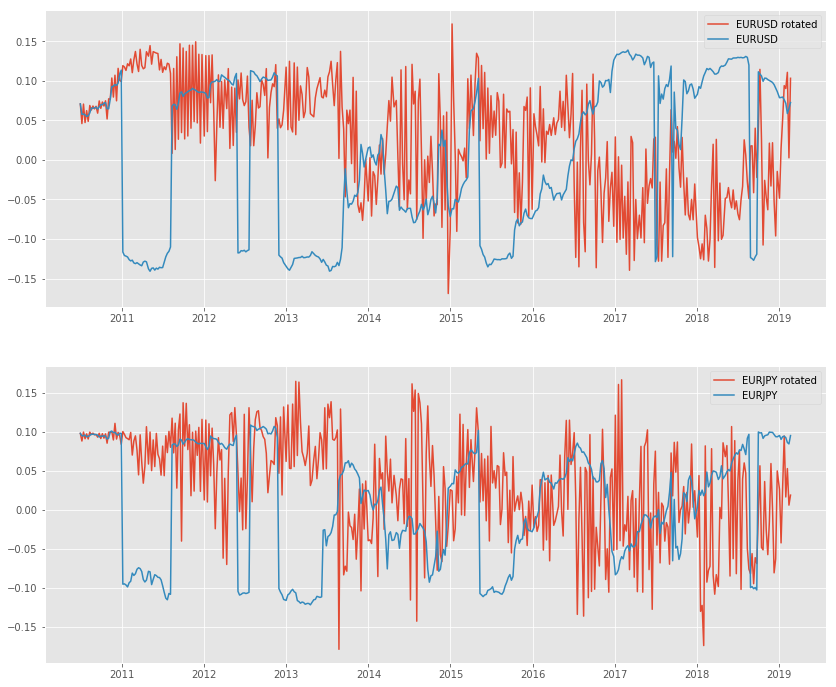

In [195]:
pc1_rot = pd.DataFrame(pc1_score_rot.transpose(),
                   columns = log_data_all.columns,
                   index = log_data_all.index[window::length])
pc1 = pd.DataFrame(pc1_score.transpose(),
                   columns = log_data_all.columns,
                   index = log_data_all.index[window::length])

fig, ax = plt.subplots(2,1,figsize = (14,12))
ax[0].plot(pc1_rot.index,pc1_rot['EURUSD'].values,label ='EURUSD rotated')
ax[0].plot(pc1_rot.index,pc1['EURUSD'].values,label ='EURUSD')
ax[1].plot(pc1_rot.index,pc1_rot['EURJPY'].values,label ='EURJPY rotated')
ax[1].plot(pc1_rot.index,pc1['EURJPY'].values,label ='EURJPY')
ax[0].legend()
ax[1].legend()
plt.show()

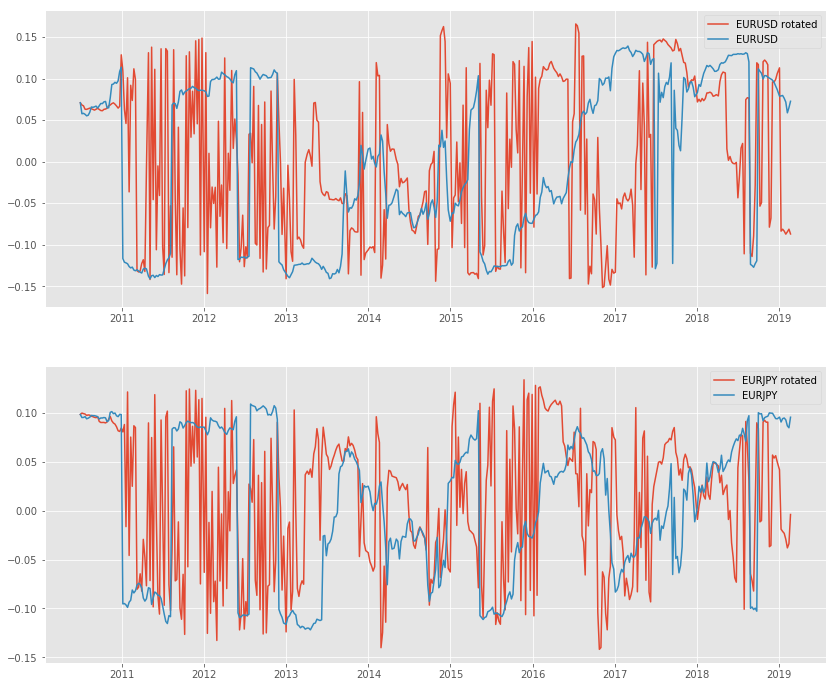

In [189]:
pc1_rot = pd.DataFrame(pc1_score_rot.transpose(),
                   columns = log_data_all.columns,
                   index = log_data_all.index[window::length])
pc1 = pd.DataFrame(pc1_score.transpose(),
                   columns = log_data_all.columns,
                   index = log_data_all.index[window::length])

fig, ax = plt.subplots(2,1,figsize = (14,12))
ax[0].plot(pc1_rot.index,pc1_rot['EURUSD'].values,label ='EURUSD rotated')
ax[0].plot(pc1_rot.index,pc1['EURUSD'].values,label ='EURUSD')
ax[1].plot(pc1_rot.index,pc1_rot['EURJPY'].values,label ='EURJPY rotated')
ax[1].plot(pc1_rot.index,pc1['EURJPY'].values,label ='EURJPY')
ax[0].legend()
ax[1].legend()
plt.show()

In [173]:
from scipy.linalg import subspace_angles

In [177]:
pc1_score.shape

(190, 444)

In [179]:
subspace_angles(pc1_score[:,0].reshape(-1,1),pc1_score[:,1].reshape(-1,1))

array([0.0922181])

In [187]:
i = 110
print(subspace_angles(pc1_score[:,i-1].reshape(-1,1),pc1_score[:,i].reshape(-1,1)))
print(subspace_angles(pc1_score_rot[:,i-1].reshape(-1,1),pc1_score_rot[:,i].reshape(-1,1)))

[0.09339552]
[0.16131824]


In [250]:
def proc2(u,u_prior):
    C = np.matmul(u.T,u_prior)
    U,S,V = np.linalg.svd(C)
    R = np.matmul(U,V.T)
    return np.matmul(u,R)

In [232]:
window = 120
length = 10
num_windows = (len(log_data_all)-window)//length+1
num_components = 5
explained = np.zeros((num_components+1,num_windows))

pc_hist_rot = np.zeros((num_windows,log_data_all.shape[1],num_components))
pc_hist = np.zeros((num_windows,log_data_all.shape[1],num_components))

angles = np.zeros((num_components,num_windows))
angles_rot =  np.zeros((num_components,num_windows))

cor_hist = np.zeros(num_windows)
cor_hist_rot =  np.zeros(num_windows)

cor = np.zeros(sub_log.shape[1])
cor_rot = np.zeros(sub_log.shape[1])

i =0
#start loop
sub_log = log_data_all.iloc[i*length:(i*length)+window,:]
u, s, vh = np.linalg.svd(sub_log.corr())
pc_hist_rot[i,:,:] = u[:,0:num_components]
pc_hist[i,:,:] = u[:,0:num_components]
explained[0,i] = s[0:num_components].sum()/s.sum()
explained[1:,i] = s[0:num_components]/s.sum()

prior_u = u[:,0:num_components]

pc_scores = np.matmul(sub_log.values ,u[:,0:num_components])
pc_scores_rot = np.matmul(sub_log.values ,prior_u)

sub_log_hat=np.matmul(pc_scores,u[:,0:num_components].transpose())
sub_log_rot=np.matmul(pc_scores,prior_u.transpose())




for j in range(sub_log.shape[1]):
    cor[j]=np.corrcoef(sub_log.iloc[:,j].values,sub_log_hat[:,j])[0][1]
    cor_rot[j]=np.corrcoef(sub_log.iloc[:,j].values,sub_log_rot[:,j])[0][1]

cor_hist[i] = np.mean(cor)
cor_hist_rot[i] = np.mean(cor_rot)

for i in range(1,num_windows):
    sub_log = log_data_all.iloc[i*length:(i*length)+window,:]
    u, s, vh = np.linalg.svd(sub_log.corr())
    pc_hist[i,:,:] = u[:,0:num_components]
    explained[0,i] = s[0:num_components].sum()/s.sum()
    explained[1:,i] = s[0:num_components]/s.sum()
    #rotate factors
    #r = proc.procrustes(u[:,0:num_components],prior_u)
    prior_u = proc2(u[:,0:num_components],prior_u)
    pc_hist_rot[i,:,:] = prior_u
    
    #get scores for R2 test
    pc_scores = np.matmul(sub_log.values ,u[:,0:num_components])
    pc_scores_rot = np.matmul(sub_log.values ,prior_u)
    #calc scores
    sub_log_hat=np.matmul(pc_scores,u[:,0:num_components].transpose())
    sub_log_rot=np.matmul(pc_scores,prior_u.transpose())
    
    for j in range(sub_log.shape[1]):
        cor[j]=np.corrcoef(sub_log.iloc[:,j].values,sub_log_hat[:,j])[0][1]
        cor_rot[j]=np.corrcoef(sub_log.iloc[:,j].values,sub_log_rot[:,j])[0][1]
    
    cor_hist[i] = np.mean(cor)
    cor_hist_rot[i] = np.mean(cor_rot)
    angles[:,i] = [np.rad2deg(np.arccos(np.dot(pc_hist[i-1][:,j].T,pc_hist[i][:,j]))) 
                   for i in range(num_components)]
    angles_rot[:,i] = [np.rad2deg(np.arccos(np.dot(pc_hist[i-1][:,j].T,pc_hist_rot[i][:,j]))) 
                   for i in range(num_components)]

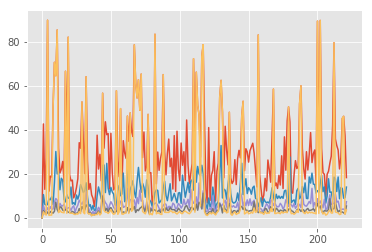

In [239]:
plt.plot(angles_rot.transpose())

In [198]:
print(sub_log.shape)
pc_scores = np.matmul(sub_log.values ,u[:,0:num_components])
sub_log_hat=np.matmul(pc_scores,u[:,0:num_components].transpose())


(120, 190)


In [203]:
cor = np.zeros(sub_log.shape[1])
for i in range(sub_log.shape[1]):
    cor[i]=np.corrcoef(sub_log.iloc[:,i].values,sub_log_hat[:,i])[0][1]

In [225]:
np.rad2deg(subspace_angles(prior_u,u[:,0:num_components]))

(5,)

In [263]:
r = proc.procrustes(pc_hist[0],pc_hist[3])
print(np.rad2deg(subspace_angles(pc_hist[0],pc_hist[3])))
print(np.rad2deg(subspace_angles(pc_hist[0],np.matmul(pc_hist[3],r))))
print(subspace_angles(pc_hist[3],np.matmul(pc_hist[3],r)))

[31.93191387 11.95353163 10.23160708  5.88133847  5.22505919]
[31.93191387 11.95353163 10.23160708  5.88133847  5.22505919]
[7.30957340e-16 6.58460572e-16 3.17314919e-16 2.73835622e-16
 2.27404605e-16]


In [262]:
print(np.matmul(pc_hist[3],r)[0,:])
print(pc_hist[3][0,:])

[-0.0805308  -0.07248771 -0.02620519 -0.08011039 -0.04647672]
[-0.08490304 -0.09693133 -0.05306889 -0.03855092 -0.00987217]


In [269]:
np.arccos(np.abs(pc_hist[0][:,0].T*pc_hist[3][:,0]))

array([1.56339838, 1.56877679, 1.570772  , 1.5664827 , 1.57077647,
       1.5704648 , 1.56143591, 1.56734021, 1.57035243, 1.56355693,
       1.56671729, 1.57077512, 1.56905686, 1.56476528, 1.57055155,
       1.56732881, 1.56866599, 1.566582  , 1.567613  , 1.56058264,
       1.56935522, 1.56115022, 1.56451181, 1.57034634, 1.56866854,
       1.56651041, 1.57079376, 1.57078976, 1.56796327, 1.5707885 ,
       1.55974603, 1.56452014, 1.56800801, 1.56057044, 1.56684769,
       1.57002163, 1.56937712, 1.5607195 , 1.56935964, 1.56043727,
       1.56144311, 1.5599982 , 1.56105143, 1.55993522, 1.5595716 ,
       1.56039525, 1.55994854, 1.5658436 , 1.56265373, 1.56641899,
       1.57077709, 1.56712762, 1.55948458, 1.55776234, 1.56193311,
       1.56509828, 1.5705142 , 1.57062425, 1.56867913, 1.56927318,
       1.56838505, 1.57023105, 1.56924583, 1.5599292 , 1.56602474,
       1.56925185, 1.56074812, 1.5684592 , 1.57051998, 1.56541744,
       1.56260874, 1.56196271, 1.56071258, 1.56305573, 1.56065

In [278]:
[np.rad2deg(np.arccos(np.dot(pc_hist[0][:,i].T,
                             pc_hist[1][:,i])))
                                for i in range(num_components)]


[5.685625309483793,
 14.159387940560741,
 48.63950501317762,
 54.09234081440589,
 42.16964427675186]